In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

print ("Numpy Version - ", np.__version__)
print ("Pandas Version - ", pd.__version__)

Numpy Version -  1.18.5
Pandas Version -  1.0.5


In [2]:
# Setting collaterals path
dataset_path = r"datasets/"

In [3]:
# Function to preprocess the data
def conv_gender (x):
    if x == "Male":
        return 0
    else:
        return 1 

def conv_ever_married (x):
    if x == "No":
        return 0
    else:
        return 1
    
def conv_work_type (x):
    if x == "Private":
        return 0
    elif x == "Self-employed":
        return 1
    elif x == "Govt_job":
        return 2
    elif x == "children":
        return 3
    else:
        return 4    
    
def conv_residence_type (x):
    if x == "Rural":
        return 0
    else:
        return 1

def conv_smoking_status (x):
    if x == "never smoked":
        return 0
    elif x == "formerly smoked":
        return 1
    elif x == "smokes":
        return 2
    else:
        return 3

def normalization (x, min, max):
    normalize = (x - min)/(max - min)
    return float(normalize)

In [4]:
stroke_data_df = pd.read_csv(dataset_path + "healthcare-dataset-stroke-data.csv")
stroke_data_df = stroke_data_df.fillna(0)
stroke_data_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,0.0,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# Digitizing text column
stroke_data_df ['gender_digitized'] = stroke_data_df['gender'].apply(conv_gender)
stroke_data_df ['ever_married_digitized'] = stroke_data_df['ever_married'].apply(conv_ever_married)
stroke_data_df ['work_type_digitized'] = stroke_data_df['work_type'].apply(conv_work_type)
stroke_data_df ['residence_type_digitized'] = stroke_data_df['Residence_type'].apply(conv_residence_type)
stroke_data_df ['smoking_status_digitized'] = stroke_data_df['smoking_status'].apply(conv_smoking_status)

In [6]:
avg_glucose_level_min = stroke_data_df['avg_glucose_level'].min()
avg_glucose_level_max = stroke_data_df['avg_glucose_level'].max()

bmi_min = stroke_data_df['bmi'].min()
bmi_max = stroke_data_df['bmi'].max()

age_min = stroke_data_df['age'].min()
age_max = stroke_data_df['age'].max()

print("Age - ", stroke_data_df['age'].min(), stroke_data_df['age'].max())
print("Average Glucose Level - ", stroke_data_df['avg_glucose_level'].min(), stroke_data_df['avg_glucose_level'].max())
print("BMI - ", stroke_data_df['bmi'].min(), stroke_data_df['bmi'].max())

Age -  0.08 82.0
Average Glucose Level -  55.12 271.74
BMI -  0.0 97.6


In [7]:
# Normalizing fields
stroke_data_df['age_norm'] = stroke_data_df['age'].apply(normalization, args=(age_min, age_max))
stroke_data_df['avg_glucose_level_norm'] = stroke_data_df['avg_glucose_level'].apply(normalization, args=(avg_glucose_level_min, avg_glucose_level_max))
stroke_data_df['bmi_norm'] = stroke_data_df['bmi'].apply(normalization, args=(bmi_min, bmi_max))

In [8]:
# Creating new dataframe for machine learning
stroke_data_proc_df = stroke_data_df [['gender_digitized', 'age', 'hypertension', 'heart_disease',
                                       'ever_married_digitized', 'work_type_digitized', 'residence_type_digitized',
                                       'avg_glucose_level', 'bmi', 'smoking_status_digitized', 'stroke']]

stroke_data_proc_df = stroke_data_proc_df.astype('int32')
stroke_data_proc_df.head()

,gender_digitized,age,hypertension,heart_disease,ever_married_digitized,work_type_digitized,residence_type_digitized,avg_glucose_level,bmi,smoking_status_digitized,stroke
0,0,67,0,1,1,0,1,228,36,1,1
1,1,61,0,0,1,1,0,202,0,0,1
2,0,80,0,1,1,0,0,105,32,0,1
3,1,49,0,0,1,0,1,171,34,2,1
4,1,79,1,0,1,1,0,174,24,0,1


In [9]:
# Separate out the datasets for training and testing
stroke_data0_proc_df = stroke_data_proc_df[stroke_data_proc_df['stroke'] == 0]
stroke_data1_proc_df = stroke_data_proc_df[stroke_data_proc_df['stroke'] == 1]

# Splitting datasets with stroke == 0
stroke_data0_split1_df = stroke_data0_proc_df.sample(frac=0.8,random_state=200)
stroke_data0_split2_df = stroke_data0_proc_df.drop(stroke_data0_split1_df.index)

# Splitting datasets with stroke == 1
stroke_data1_split1_df = stroke_data1_proc_df.sample(frac=0.8,random_state=200)
stroke_data1_split2_df = stroke_data1_proc_df.drop(stroke_data1_split1_df.index)

# Creating train and test datasets
train_data = pd.concat([stroke_data0_split1_df, stroke_data1_split1_df], ignore_index=True)
test_data = pd.concat([stroke_data0_split2_df, stroke_data1_split2_df], ignore_index=True)

# Partitioning X and y data for both train and test datasets
X_train = train_data.iloc[:,0:-1]
y_train = train_data.iloc[:,-1]
X_test = test_data.iloc[:,0:-1]
y_test = test_data.iloc[:,-1]

features = list(X_train.columns)

In [10]:
# Training the decision tree with training datasets
stroke_dtree = DecisionTreeClassifier(criterion='entropy', random_state=1000)
# train the tree
stroke_dtree.fit(X_train, y_train)
print("Depth of tree=", stroke_dtree.tree_.max_depth)

Depth of tree= 19


[Text(155.0660101744186, 371.007, 'X[1] <= 53.5\nentropy = 0.281\nsamples = 4088\nvalue = [3889, 199]'),
 Text(55.945988372093026, 351.981, 'X[1] <= 37.5\nentropy = 0.085\nsamples = 2614\nvalue = [2586, 28]'),
 Text(10.38139534883721, 332.955, 'X[7] <= 76.5\nentropy = 0.019\nsamples = 1623\nvalue = [1620, 3]'),
 Text(8.305116279069768, 313.929, 'X[8] <= 6.5\nentropy = 0.058\nsamples = 451\nvalue = [448, 3]'),
 Text(4.152558139534884, 294.90299999999996, 'X[0] <= 0.5\nentropy = 0.469\nsamples = 10\nvalue = [9, 1]'),
 Text(2.076279069767442, 275.87699999999995, 'entropy = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(6.228837209302326, 275.87699999999995, 'X[6] <= 0.5\nentropy = 0.918\nsamples = 3\nvalue = [2, 1]'),
 Text(4.152558139534884, 256.851, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(8.305116279069768, 256.851, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(12.457674418604652, 294.90299999999996, 'X[8] <= 28.5\nentropy = 0.042\nsamples = 441\nvalue = [439, 2]'),
 Text

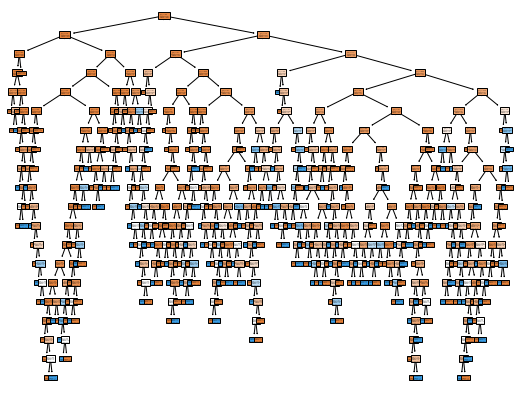

In [11]:
figure(figsize=(9,7))
tree.plot_tree(stroke_dtree, filled=True, impurity=True)

In [12]:
# Using decision tree to predict
display (X_test)
stroke_dtree.predict(X_test)

,gender_digitized,age,hypertension,heart_disease,ever_married_digitized,work_type_digitized,residence_type_digitized,avg_glucose_level,bmi,smoking_status_digitized
0,1,8,0,0,0,0,1,110,17,3
1,1,42,0,0,1,0,0,82,22,0
2,1,79,0,1,1,1,1,67,25,2
3,1,23,0,0,0,0,1,94,30,0
4,0,59,0,0,1,0,1,117,29,2
...,...,...,...,...,...,...,...,...,...,...
1017,1,81,0,0,0,2,1,70,25,2
1018,1,81,0,0,1,1,0,81,16,0
1019,0,66,0,0,1,0,0,76,21,1
1020,0,57,0,0,1,0,0,84,36,3


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

[0.04191343 0.33092978 0.02502723 0.0204149  0.0194674  0.0361391
 0.02877236 0.26224332 0.15787915 0.07721333]


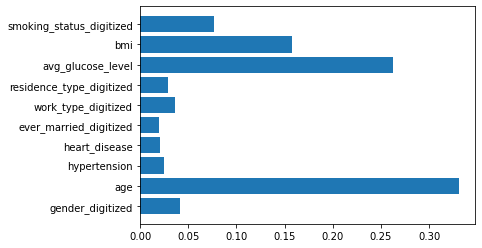

In [13]:
# Features importance of decision tree
fig, ax = plt.subplots()
ax.barh(features, stroke_dtree.feature_importances_)
print(stroke_dtree.feature_importances_)

In [14]:
y_predict = stroke_dtree.predict(X_test)
print ("Stroke Predictions Results = ")
print (y_predict)

Stroke Predictions Results = 
[0 0 0 ... 0 0 0]


In [15]:
# Training the pruned decision tree with training datasets - depth:15
stroke_pruned_dtree = DecisionTreeClassifier(criterion='entropy', max_depth=17, random_state=500)
# train the pruned tree
stroke_pruned_dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=17, random_state=500)

In [16]:
y_pruned_predict = stroke_pruned_dtree.predict(X_test)
print ("Stroke Pruned Predictions Results = ")
print (y_pruned_predict)

Stroke Pruned Predictions Results = 
[0 0 0 ... 0 0 0]


In [17]:
# Create Confusion Matrix for Accuracy Analysis
cm_f = confusion_matrix(y_test, y_predict)
cm_p = confusion_matrix(y_test, y_pruned_predict)

print (cm_f)
print (cm_p)

[[920  52]
 [ 40  10]]
[[930  42]
 [ 37  13]]


Confusion matrix (Full Tree)
Accuracy - 0.9099804305283757
Precision - 0.16129032258064516
Recall - 0.2


Confusion matrix (Pruned Tree)
Accuracy - 0.9227005870841487
Precision - 0.23636363636363636
Recall - 0.26




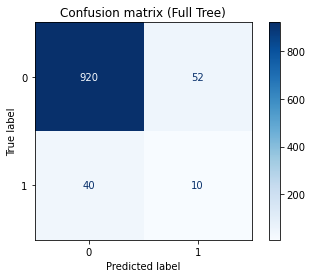

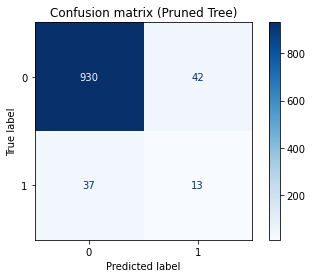

In [18]:
titles_options = [("Confusion matrix (Full Tree)", stroke_dtree, y_predict),
                  ("Confusion matrix (Pruned Tree)", stroke_pruned_dtree, y_pruned_predict)]

for title, classifier, predict in titles_options:
    
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)
    print (title)
    # Report the Accuracy of the model
    print ("Accuracy -", accuracy_score(y_test, predict, sample_weight=None))
    # Report the Precision of the model (Tp/Tp+Fp)
    print ("Precision -", precision_score(y_test, predict, sample_weight=None))
    # Report the Recall of the model (Tp/Tp+Fn)
    print ("Recall -", recall_score(y_test, predict, sample_weight=None))
    print ("\n")

plt.show()